# CITS5508 Lab 3: Random Forest Classifier on Parkinsons

Name: Joey Koh<br>
Student number: 21506379  
Date created: 13 April 2020  
Last modified: 20 April 2020  

This notebook goes through the steps of a Random Forest Classification project. It is addressing a classification task on predicting Parkinsons status using vocal.<br>

A Support Vector Machine Classifier, Logistic Regression, and Gradient Descent Classifier are used in ensemble and judged in performance.

- [ ] fix notes
- [ ] search and fix EDIT
- [ ] search and remove all REMOVE

ask:
- how to use drop/loc
- feature scaling using training_x data right?
- accuracy and f1 score difference?
- imbalanced binary, how to deal

## 1. Setup, Data Cleaning and Visualisation
Import libraries to be used and bring the data in. Clean the data for use.<br>
Perform basic visualisations to have a feel of data.<br>

In [7]:
import pandas as pd
import numpy as np
import sklearn as sk
#Use jupyter's backend to render plots
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
#warnings.filterwarnings("ignore")

#Prepare the data, separate cols by whitespace, give col names
raw_data = pd.read_csv("parkinsons.data")
#View first few lines and inspect columns
raw_data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


### 1.1 Data Cleaning
There are quite a few columns, so let's look at all of them.

In [6]:
#view all columns
with pd.option_context( 'display.max_columns', None):  # more options can be specified also
    print(raw_data)

               name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0    phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1    phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2    phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3    phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4    phon_R01_S01_5      116.014       141.781       110.655         0.01284   
..              ...          ...           ...           ...             ...   
190  phon_R01_S50_2      174.188       230.978        94.261         0.00459   
191  phon_R01_S50_3      209.516       253.017        89.488         0.00564   
192  phon_R01_S50_4      174.688       240.005        74.287         0.01360   
193  phon_R01_S50_5      198.764       396.961        74.904         0.00740   
194  phon_R01_S50_6      214.289       260.277        77.973         0.00567   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:P

With the data description as well, we confirm that only 'name' is non-numerical. It is the 'ASCII subject name and recording number' of 31 people with around 6 recordings per person. As we are trying to use speech signals and not the individual's identity to classify the health status, we can **drop the 'name' column**.

In [13]:
data = raw_data.drop('name', axis= 1)
print("Are there any undefined values?")
print(data.isnull().values.any()) #ensure no undefined values left to fix


Are there any undefined values?
False


Good, no problems here with NaN values.

## 2. Pipeline: Data Splitting, and Normalisation
Split dataset, extract labels, investigate need for data normalisation, and create pipeline.

In [16]:
#Split dataset at 8:2 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state= 42) #with set randomseed
train_data = train_data.reset_index(drop=True) #renumber index
test_data = test_data.reset_index(drop=True) #renumber index
#Ensure no NaN values
print("are there any NaN values created for test data and train data?")
print(test_data.isnull().values.any()," and ",train_data.isnull().values.any(), "for both" )


are there any NaN values created for test data and train data?
False  and  False for both


As checked, there are no undefined values after data splitting.

In [18]:
#Produce normalised dataset and un-normalised dataset for comparison.
def separate_pipeline(df): #separate data into labels and predictors
    df_y = df["status"]  #Extract class labels
    print("For this dataset, these are the number of instances for each class label")
    print(df_y.value_counts(),"\n")   #Count instances for class labels in training set
    df_x = df.drop("status", axis=1) #separate predictors from labels
    #REMOVE print(df_x.describe(),'\n')  #get an idea of the data distribution
    return df_y, df_x

def scaler_pipeline(df,df_train_x): #for feature scaling
    std_scaler = StandardScaler()
    std_scaler.fit(df_train_x)
    return std_scaler.transform(df)
    
def main_pipeline(train_dataset, test_dataset): #bringing it all together
    print("For the training dataset:\n")
    train_y, train_x = separate_pipeline(train_dataset)
    print("For the testing dataset:\n")
    test_y, test_x = separate_pipeline(test_dataset)
    train_x_tr = scaler_pipeline(train_x, train_x)
    test_x_tr = scaler_pipeline(test_x, train_x)
    return train_y, train_x, test_y, test_x, train_x_tr, test_x_tr

train_y, train_x, test_y, test_x, train_x_tr, test_x_tr = main_pipeline(train_data, test_data)


For the training dataset:

For this dataset, these are the number of instances for each class label
1    115
0     41
Name: status, dtype: int64 

For the testing dataset:

For this dataset, these are the number of instances for each class label
1    32
0     7
Name: status, dtype: int64 



Good, there are some instances for each of the 2 classes to train with.<br>
**Note: 0 = healthy, 1 = unhealthy (has Parkinsons)**

## 3. Random Forest Classifier #1
All available cores with 500 trees and max 16 nodes.

In [43]:
randf1_clf = RandomForestClassifier(n_estimators= 500, max_leaf_nodes= 16, n_jobs= -1)

#fit with transformed training data
randf1_clf.fit(train_x_tr,train_y);
#generate test data label predictions
test_y_randf1_tr_pred = randf1_clf.predict(test_x_tr)

#fit with non-normalised training data
randf1_clf.fit(train_x, train_y);
#generate predictions
test_y_randf1_pred = randf1_clf.predict(test_x)


### 3.1 Confusion Matrix 

In [23]:
def conf_matrix(actual_y, pred_y, model): #confusion matrix function for plotting
    #confusion matrix generation
    conf_mx = confusion_matrix(actual_y, pred_y)
    print("This is the confusion matrix for",model,"\n",conf_mx)

    #visualisation setup
    alpha = ['healthy', 'unhealthy']
    conf_data = conf_mx

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_data, interpolation='nearest')
    fig.colorbar(cax)

    ax.set_xticklabels(['']+alpha)
    ax.set_yticklabels(['']+alpha)

    plt.show
    print("Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis")
    
def report_scores(actual_y, pred_y): #F1 score function
    print("F1 scores of prediction for each class:")
    print(metrics.f1_score(actual_y, pred_y, average= "micro"))

This is the confusion matrix for random forest #1 transformed 
 [[ 5  2]
 [ 0 32]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


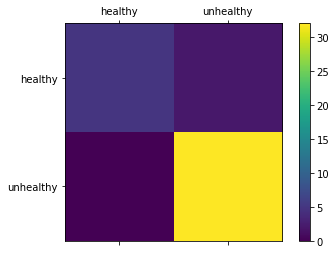

In [28]:
#Confusion matrix for randf1 transformed data
conf_matrix(test_y,test_y_randf1_tr_pred, "random forest #1 transformed")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class healthy: 5 correctly predicted, 2 wrongly predicted
* Class unhealthy: 32 correctly predicted, none wrongly predicted

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class healthy: 5 correctly predicted, 2 wrongly predicted
* Class unhealthy: 32 correctly predicted, none wrongly predicted

This is the confusion matrix for random forest #1 not normalised 
 [[ 5  2]
 [ 0 32]]
Plotting with predicted test dataset labels on horizontal axis, actuals labels on vertical axis


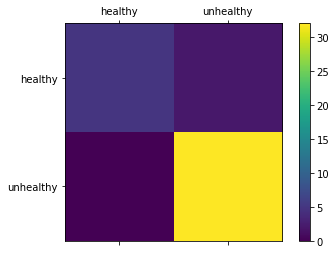

In [29]:
#Confusion matrix for randf1 not normalised data
conf_matrix(test_y,test_y_randf1_pred, "random forest #1 not normalised")

In [36]:
#Get scores
print("For transformed data trained model:")
report_scores(test_y, test_y_randf1_tr_pred)

print("\n For not normalised data trained model:")
report_scores(test_y, test_y_randf1_pred)


For transformed data trained model:
F1 scores of prediction for each class:
0.9487179487179487

 For not normalised data trained model:
F1 scores of prediction for each class:
0.9487179487179487


**Results**: Both F1 scores of 0.949 are **identical**. Let's look at another Random Forest classifier.

## 4. Random Forest Classifer #2

In [42]:
randf2_clf = RandomForestClassifier(criterion='entropy', n_estimators= 400, max_leaf_nodes= 14, n_jobs= -1)

#fit with transformed training data
randf2_clf.fit(train_x_tr,train_y);
#generate test data label predictions
test_y_randf2_tr_pred = randf2_clf.predict(test_x_tr)

#fit with non-normalised training data
randf2_clf.fit(train_x, train_y);
#generate predictions
test_y_randf2_pred = randf2_clf.predict(test_x)


### 4.1 Confusion Matrix 

In [ ]:
#Confusion matrix for randf2 transformed data
conf_matrix(test_y,test_y_randf2_tr_pred, "random forest #2 transformed")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 29 correctly predicted, 1 wrongly predicted as 'pp'
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 2 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [ ]:
report_scores(test_y, test_y_svm_pred_tuned)

As the gridsearch results indicate new hyperparameter values as the best in the tested range of values, the accuracy score and confusion matrix **improves** on the un-tuned version's.

## 4. Logistic Regression Classifier

In [ ]:
#fit log regression model with training data
log_clf = LogisticRegression()
log_clf.fit(train_x_tr, train_y)

#get test data label predictions
test_y_log_pred = log_clf.predict(test_x_tr)

### 4.1 Confusion Matrix

In [ ]:
conf_matrix(test_y, test_y_log_pred, "log regression")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1,1 wrongly predicted as 'im','pp' respectively
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [ ]:
report_scores(test_y, test_y_log_pred)

### 4.2 Tune Hyperparameters with Grid Search

In [ ]:
param_grid = {'penalty':('l1', 'l2'), 
              'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'intercept_scaling':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
             }

log_clf = LogisticRegression()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_log = GridSearchCV(log_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_log = grid_search_log.fit(train_x_tr, train_y)

In [ ]:
print('Best Score: ', grid_result_log.best_score_)
print('Best Params: ', grid_result_log.best_params_)

**Results:** looking up the LogReg documentation, the best hyperparameters from the gridsearch has a different 'penalty':'l1' compared to the default setting of 'l2'. Hence, we try it instead.

In [ ]:
test_y_log_pred_tuned = grid_result_log.predict(test_x_tr) #Get predictions from grid search result

### 4.3 Confusion Matrix after Grid Search

In [ ]:
#confusion matrix generation
conf_matrix(test_y, test_y_log_pred_tuned, "Log tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1,1 wrongly predicted as 'im','pp' respectively
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 11 correctly predicted, 1 wrongly predicted as 'cp'

In [ ]:
report_scores(test_y, test_y_log_pred_tuned)

As the gridsearch results indicate new hyperparameter values as the best in the tested range of values, the accuracy score and confusion matrix **should improve** on the un-tuned version's. But it doesn't appear to be so, with similar scores.


## 5. Stochastic Gradient Descent Classifier

In [ ]:
#fit SGD model with training data
sgd_clf = SGDClassifier(random_state= 63) #set a randomseed
sgd_clf.fit(train_x_tr, train_y);

#generate test data label prediction
test_y_sgd_pred = sgd_clf.predict(test_x_tr)

### 5.1 Confusion Matrix 

In [ ]:
#confusion matrix generation
conf_matrix(test_y, test_y_sgd_pred, "SGD")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 1 correctly predicted, 4,1 wrongly predicted as 'im','pp'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 10 correctly predicted, 1,1 wrongly predicted as 'cp','im'

In [ ]:
report_scores(test_y, test_y_sgd_pred)

### 5.2 Tune Hyperparameters with Grid Search

In [ ]:
param_grid = {'loss':('hinge', 'log', 'modified_huber', 'perceptron'), 
              'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l2','l1','elasticnet'],
              'random_state':[63]
             }

sgd_clf = SGDClassifier()
scorer = sk.metrics.make_scorer(sk.metrics.f1_score, average = 'micro')

grid_search_sgd = GridSearchCV(sgd_clf, 
                               param_grid, 
                               scoring = scorer,
                               return_train_score = True)

grid_result_sgd = grid_search_sgd.fit(train_x_tr, train_y)

In [ ]:
print('Best Score: ', grid_result_sgd.best_score_)
print('Best Params: ', grid_result_sgd.best_params_)

**Results:** looking up the SGDClassifier documentation, the default hyperparameters would be {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}. As the grid search result is not identical, we should expect a better performance from the tuned settings. Hence, the accuracy and confusion matrix should be different.

In [ ]:
test_y_sgd_pred_tuned = grid_result_sgd.predict(test_x_tr) #Get predictions from grid search result

### 5.3 Confusion Matrix after Grid Search

In [ ]:
#confusion matrix generation
conf_matrix(test_y, test_y_sgd_pred_tuned, "SGD tuned")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 10 correctly predicted, 2 wrongly predicted as 'cp'

In [ ]:
report_scores(test_y,test_y_sgd_pred_tuned)

As the gridsearch results indicate new hyperparameter values as the best in the tested range of values, the accuracy score and confusion matrix **has improved** on the un-tuned version's


## 6. Voting Classifier

In [ ]:
#REMOVE
#create and fit training data with voting classifier
voting_clf = VotingClassifier(
    estimators=[('svc', svm_clf), ('lr', log_clf), ('sgd', sgd_clf)],
    voting='hard')
voting_clf.fit(train_x_tr, train_y)

#generate test data label prediction
test_y_voting_pred = voting_clf.predict(test_x_tr)

In [ ]:
#REMOVE
#Check each classfier's accuracy scores used in voting_clf
for clf in (svm_clf, log_clf, sgd_clf, voting_clf):
    clf.fit(train_x_tr, train_y)
    checking_y_pred = clf.predict(test_x_tr)
    print(clf.__class__.__name__, sk.metrics.accuracy_score(test_y, checking_y_pred))

In [ ]:
#create and fit training data with voting classifier
voting_clf = VotingClassifier(
    estimators=[('svc', grid_search_svm), ('lr', grid_search_log), ('sgd', grid_search_sgd)],
    voting='hard')
voting_clf.fit(train_x_tr, train_y)

#generate test data label prediction
test_y_voting_pred = voting_clf.predict(test_x_tr)


In [ ]:
#Check each classfier's accuracy scores used in voting_clf
for clf in (svm_clf, log_clf, sgd_clf, voting_clf):
    clf.fit(train_x_tr, train_y)
    checking_y_pred = clf.predict(test_x_tr)
    print(clf.__class__.__name__, sk.metrics.accuracy_score(test_y, checking_y_pred))

In [ ]:
#generate confusion matrix
conf_matrix(test_y, test_y_voting_pred, "voting classifier")

**Results:** Each row represents an actual class, while each column represents a predicted class. The classification results are thus:
* Class cp: 30 correctly predicted, none wrongly predicted
* Class im: 14 correctly predicted, 1 wrongly predicted as 'cp'
* Class imU: 4 correctly predicted, 1 wrongly predicted as 'im'
* Class om: 3 correctly predicted, none wrongly predicted
* Class pp: 10 correctly predicted, 1 wrongly predicted as 'cp'

In [ ]:
report_scores(test_y, test_y_voting_pred)

## 7. Conclusion

<p>The accuracy score of the untuned and tuned Support Vector Classifier were identical, at 91.9%. This was due to the hyperparameters from the grid search matching the default hyperparameters.</p>

<p>The accuracy score of the untuned Stochastic Gradient Descent Classifier was 93.4%, while the tuned version had a score of 90.9%. As the grid search's resulting hyperparameters were not identical to the default settings, this change is expected. The accuracy score, and thus performance, was found to be lower. However, this is due to the system ending up fine-tuned to perform well on the validation data and it is unlikely to perform as well on unknown datasets. Trying to manually tweak the parameters to make the performance look good on the test dataset would result in the changes being unlikely to generalise well with any new data.
</p>

<p>Overall, the performance of the Support Vector Classifier is comparable to the Stochastic Gradient Descent Classifier.</p>